# Training linear nets

In [8]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


In [2]:
def rep_error_deep_decoder(img_np,net,net_input,convert2ycbcr=False):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    img_var = np_to_var(img).type(dtype)
    
    rnd = 500
    numit = 2500
    rn = 0.005
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net)


def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')    
        
def comparison(img_np,net,net_input,convert2ycbcr=False):
    # compute representations
    psnrv, out_img_np, nparms = rep_error_deep_decoder(img_np,net=net,net_input=net_input,convert2ycbcr=convert2ycbcr)
    nchannels = img_np.shape[0]
    
    print("Compression factor: ", np.prod( img_np.shape ) / nparms )
    # plot results
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,out_img_np)
    ax2.set_title( "Deep-Decoder representation, PSNR: %.2f" % psnrv )
    ax2.axis('off')
    #save_np_img(img_np,"exp_comp_orig.png")
    #save_np_img(out_img_np,"exp_comp_dd.png")
    
    plt.axis('off')
    fig.show()
    
def plot_kernels(tensor):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
    num_kernels = tensor.shape[0]
    fig = plt.figure(figsize=(tensor.shape[0],tensor.shape[1]))
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax1 = fig.add_subplot(tensor.shape[0],tensor.shape[1],1+i*tensor.shape[0]+j)
            ax1.imshow(tensor[i][j])
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def apply_until(net_input,net,n = 100):
    # applies function by funtion of a network
    for i,fun in enumerate(net):
        if i>=n:
            break
        if i==0:
            out = fun(net_input.type(dtype))
        else:
            out = fun(out)
    print(i, "last func. applied:", net[i-1])
    if n == 0:
        return net_input
    else:
        return out

def plot_tensor(out,nrows=8):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

## Individual batch norm implementation

In [61]:
def pure_batch_norm(X, gamma, beta, eps = 1e-5):
    if len(X.shape) not in [4]:
        raise ValueError('only supports 2dconv')
    # extract the dimensions
    N, C, H, W = X.shape
    # mini-batch mean
    mean = torch.mean(X, axis=(0, 2, 3))
    # mini-batch variance
    variance = torch.mean((X - mean.reshape((1, C, 1, 1))) ** 2, axis=(0, 2, 3))
    # normalize
    X_hat = (X - mean.reshape((1, C, 1, 1))) * 1.0 / torch.sqrt(variance.reshape((1, C, 1, 1)) + eps)
    # scale and shift
    return gamma.reshape((1, C, 1, 1)) * X_hat + beta.reshape((1, C, 1, 1))



class ChannelNormalization(torch.nn.Module):
    def __init__(self, D_in,mode="BN"):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        self.mode = mode
        requires_grad=True
        super(ChannelNormalization, self).__init__()
        #self.gamma = Variable(torch.ones(D_in),requires_grad=requires_grad).type(dtype)
        #self.beta = Variable(torch.zeros(D_in),requires_grad=requires_grad).type(dtype)
        #self.gamma = nn.Parameter(torch.ones(D_in),requires_grad=requires_grad).type(dtype)
        #self.beta = nn.Parameter(torch.zeros(D_in),requires_grad=requires_grad).type(dtype)
        
        self.gamma = nn.Parameter(torch.ones(D_in))
        self.beta = nn.Parameter(torch.zeros(D_in))

        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        
        #return (x - torch.mean(x))/(torch.std(x) + 0.00000001 ) *self.gamma[0] + self.beta[0]
        
        #return pure_batch_norm(x, self.gamma, self.beta, eps = 1e-5)
        
        xx = Variable(torch.zeros(x.shape)).type(dtype)
        for i,(g,b) in enumerate(zip(self.gamma,self.beta)):
            #print(i, x[0][i].shape)
            if self.mode == "BN":
                #xx[:,i] = (x[:,i] - torch.mean(x[:,i]))/(torch.std(x[:,i]) + 0.00000001 ) *g + b
                #print(torch.mean(x[0][i]))
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g + b
                #xx[0][i] = (x[0][i] - torch.mean(x[0]))/(torch.std(x[0]) + 0.00000001 ) *g + b
            elif self.mode == "mult":
                xx[:,i] = x[:,i]*g + b
            elif self.mode == "non-learned":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 )
            elif self.mode == "center":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "none":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "normalize+bias":
                xx[0][i] = (x[0][i])/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g + b
            elif self.mode == "only+bias":
                xx[:,i] = x[:,i] + b
            elif self.mode == "onlycenter+bias":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))*g + b
            elif self.mode == "almostcenter":
                xx[:,i] = ( (x[:,i] - torch.mean(x[:,i])) + torch.mean(x[:,i]) / torch.from_numpy( np.sqrt( np.array([np.prod(x[0][i].shape)]) ) ).float().type(dtype)) /torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "center+scale":
                #xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( x[:,i] - torch.mean(x[:,i]) )  - torch.min( x[:,i] - torch.mean(x[:,i]) ) )
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( torch.abs(x[:,i] - torch.mean(x[:,i]) ) ) + 0.00001)
            elif self.mode == "center+mean_scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / torch.mean(torch.abs( x[:,i] - torch.mean(x[:,i]) ) )
            elif self.mode == "noise":
                #   noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
                #no = torch.norm(x[0][i].data)
                #sigma = 0.1*no
                #noise = Variable( torch.randn( x[0][i].size() ) * sigma ).type(dtype)
                #noise = Variable( x[0][i].data.new(x[0][i].size()).normal_(0, sigma))
                xx[0][i] = x[0][i] / ( torch.norm(x[0][i])* np.prod(x[0][i].shape) + 0.00001  ) + b
                #xx[0][i] = x[0][i] / torch.norm( x[0][i] )  + noise + b
                #xx[0][i] = (x[0][i] - torch.mean(x[0][i])) / torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            #elif self.mode == "center_then_normalize": # stupid; is the same as BN
            #    center =  (x[0][i] - torch.mean(x[0][i]))
            #    xx[0][i] = center / torch.sqrt( torch.var(center) + 0.00001 ) + b
            elif self.mode == "scale":
                z =  x[0][i]
                xx[0][i] = z / ( torch.norm(z) + 0.00001 )*g + b
            else:
                raise ValueError('not an option for channel normalization.')


        #x = x*self.gamma[0] + self.beta[0]
        return xx

In [4]:
#m = ChannelNormalization(4)
#m.parameters()
#print('m', list(m.parameters()))

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.xavier_uniform(m.weight)

# use the modules apply function to recursively apply the initialization
#rand_net.apply(init_normal)

## Decoder with channel normalization

In [84]:
def conv(in_f, out_f, kernel_size, stride=1, pad='zero',bias=False):
    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)

    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers)


class normalizedconv(nn.Module):
    def __init__(self,in_f, out_f, kernel_size, stride, pad, bias):
        super(normalizedconv, self).__init__()
        self.conv = conv(in_f, out_f, kernel_size, stride, pad, bias)
    def forward(self,x):
        xx = self.conv(x)
        nchannels = self.conv[1].weight.shape[0]
        for i in range(nchannels):
            xx[:,i] /= torch.norm( self.conv[1].weight[i],p=2 )
        return xx

#          self.conv1.weight /=torch.norm(self.conv1.weight, p=2, 1,keepdim=True)
#          output = self.conv1(input)

def decnet(
        num_output_channels=3, 
        num_channels_up=[128]*5, 
        filter_size_up=1,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        mode = "none",
        upsample = False,
        nonlin = False,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    print("generated net with mode ", mode)
    for i in range(len(num_channels_up)-1):
        if mode=="channeln":
            model.add(normalizedconv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1, pad='reflection',bias=False))        
        else:
            model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1, pad='reflection',bias=False))        

        if nonlin:
            model.add(act_fun)
        #model.add(nn.BatchNorm2d( num_channels_up[i+1] ,affine=True))
        if mode!= "channeln":
            model.add(ChannelNormalization(num_channels_up[i+1],mode=mode))
        #model.add(nn.BatchNorm2d( num_channels_up[i+1] ,affine=True,track_running_stats=False,momentum=0))                 
        if upsample:
            model.add(nn.Upsample(scale_factor=2, mode="bilinear"))
    
    model.add(conv( num_channels_up[-1], num_output_channels, 1, pad='reflection',bias=True))
    model.add(nn.Sigmoid())
    
    return model

In [85]:
path = './test_data/'
img_name = "phantom256"
img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)
print(img_var.shape)

torch.Size([1, 1, 256, 256])


# Version of BN on actual problem

In [86]:
num_channels = [32]*5
output_depth = 1

totalupsample = 2**len(num_channels)
width = int(img_var.data.shape[2]/totalupsample)
height = int(img_var.data.shape[3]/totalupsample)

shape = [1,num_channels[0], width,height]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=1,mode="channeln",upsample=True,nonlin = True).type(dtype)
net.apply(init_normal)

print(net)

mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=1000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                        )

shape:  [1, 32, 8, 8]
generated net with mode  channeln
Sequential(
  (1): normalizedconv(
    (conv): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (2): ReLU()
  (3): Upsample(scale_factor=2, mode=bilinear)
  (4): normalizedconv(
    (conv): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (5): ReLU()
  (6): Upsample(scale_factor=2, mode=bilinear)
  (7): normalizedconv(
    (conv): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (8): ReLU()
  (9): Upsample(scale_factor=2, mode=bilinear)
  (10): normalizedconv(
    (conv): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (11): ReLU()
  (12): Upsample(scale_factor=2, mode=bilinear)
 

(-0.5, 255.5, 255.5, -0.5)

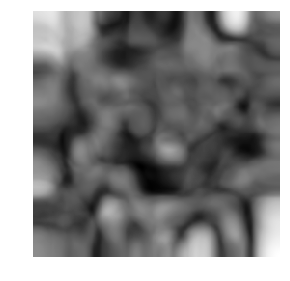

In [77]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
ax2 = fig.add_subplot(132)
myimgshow(ax2,out_img)
ax2.axis('off')

# Experiment: Effect of normalization on norm of gradients

The experiments shows that for this simple setup of only one convlayer and a linear problem, normalization efficiently avoids vanishing gradients.

In [ ]:
num_channels = [1]*10
output_depth = 1
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=51,mode="center+scale").type(dtype)

net.apply(init_normal)

mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=1000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                               )

for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05


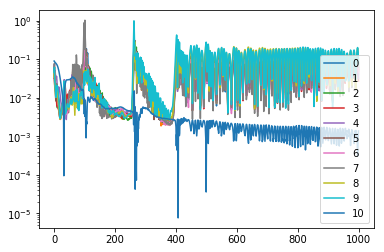

In [283]:
num_channels = [1]*10
output_depth = 1
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=51,mode="center+mean_scale").type(dtype)

net.apply(init_normal)

mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=1000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                               )

for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

In [280]:
for m in net.modules():
    if isinstance(m, ChannelNormalization):
        print(m.beta.data,m.gamma.data)
#        print(torch.norm(m.weight.data).cpu())#p='fro')
        #print(m.weights.data)

tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0') tensor([1.], device='cuda:0')


In [259]:
print(net)

Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (4): ChannelNormalization()
  (5): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (6): ChannelNormalization()
  (7): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (8): ChannelNormalization()
  (9): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (10): ChannelNormalization()
  (11): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (12): Channe

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05


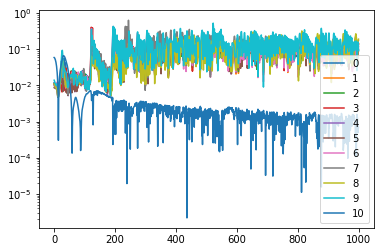

In [253]:
num_channels = [1]*10
output_depth = 1
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=51,mode="BN").type(dtype)

net.apply(init_normal)

mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=1000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                               )

for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

In [115]:
num_channels = [1]*5
output_depth = 1
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=51,mode="only+bias").type(dtype)
net.apply(init_normal)

mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=1000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                               )

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05


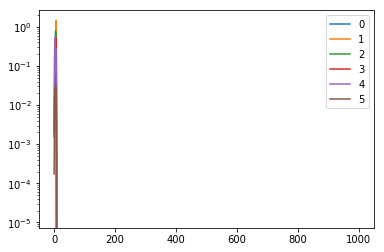

In [116]:
for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05


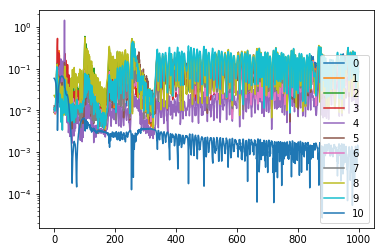

In [230]:
num_channels = [1]*10
output_depth = 1
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=51,mode="BN").type(dtype)

net.apply(init_normal)

mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=1000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                               )

for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

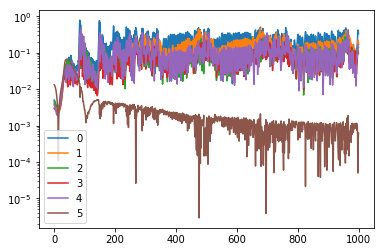

In [129]:
for i,g in enumerate(out_grads):
    plt.semilogy(g,label=str(i)) 
plt.legend()
plt.show()

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05


## Linear net, with batch norm

shape:  [1, 8, 256, 256]
input provided
optimize with SGD 0.05
Compression factor:  0.7876165753292953 Actual loss 0.003024 Actual loss orig 0.002877 


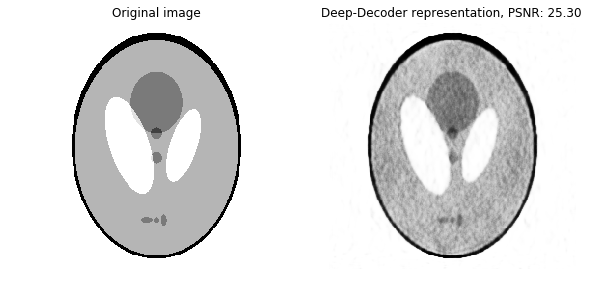

In [7]:
num_channels = [8]*15
output_depth = img_np.shape[0] # number of output channels
net = decodernw(output_depth,num_channels_up=num_channels,upsample_mode='none',act_fun=None,filter_size_up=9).type(dtype)

width = img_np.shape[1]
height = img_np.shape[2]
shape = [1,num_channels[0], width, height]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
comparison(img_np,net,net_input)

## Linear net, without batch norm

shape:  [1, 8, 256, 256]
input provided
optimize with adam 0.005
Compression factor:  0.7900472562445752 Actual loss 0.708165 Actual loss orig 0.708165  Noise Energy 0.000000 


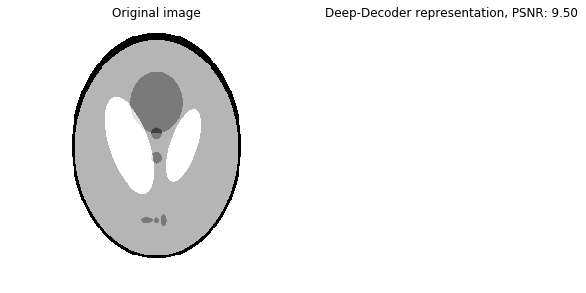

In [9]:
num_channels = [8]*15
output_depth = img_np.shape[0] # number of output channels
net = decodernw(output_depth,num_channels_up=num_channels,upsample_mode='none',bn=False,act_fun=None,filter_size_up=9).type(dtype)

width = img_np.shape[1]
height = img_np.shape[2]
shape = [1,num_channels[0], width, height]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
comparison(img_np,net,net_input)

## SGD

shape:  [1, 8, 256, 256]
input provided
optimize with SGD 0.05
Compression factor:  0.7900472562445752 Actual loss 0.112279 Actual loss orig 0.112279  Noise Energy 0.000000 


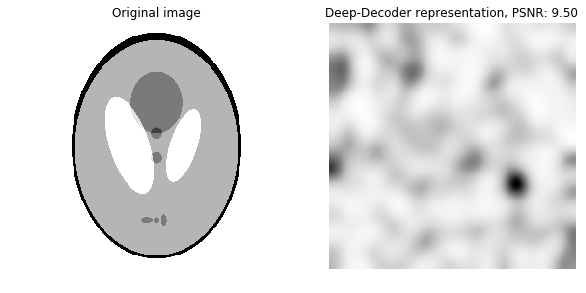

In [13]:
num_channels = [8]*15
output_depth = img_np.shape[0] # number of output channels
net = decodernw(output_depth,num_channels_up=num_channels,upsample_mode='none',bn=False,act_fun=None,filter_size_up=9).type(dtype)

width = img_np.shape[1]
height = img_np.shape[2]
shape = [1,num_channels[0], width, height]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
comparison(img_np,net,net_input)

In [363]:
num_channels = [8]*15
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

shape:  [1, 8, 256, 256]


In [309]:
output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=9,mode="BN").type(dtype)

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=100,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        #output_gradient=True,
                               )

input provided
optimize with SGD 0.05


In [321]:
#print(list(net.parameters()))

In [322]:
#for m in net.modules():
#    if isinstance(m, ChannelNormalization):
#        print("parameters:")
#        print(m.gamma)
#        print(m.beta)
        #print(m.weights.data)

# Test with different BN variants

In [226]:
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10

num_channels = [8]*15
output_depth = img_np.shape[0] # number of output channels

shape:  [1, 8, 256, 256]


## Regular BN

input provided
optimize with SGD 0.05
Compression factor:  0.8401189621577274 Actual loss 0.002191 Actual loss orig 0.002027  Noise Energy 0.000000 


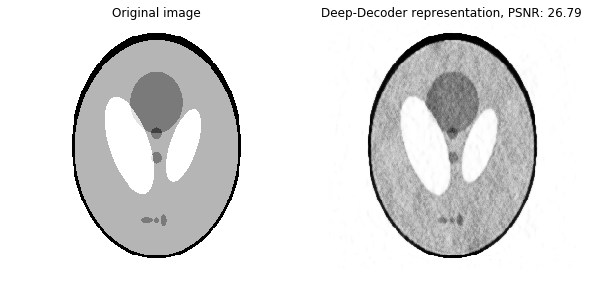

In [364]:
output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=9,mode="BN").type(dtype)

comparison(img_np,net,net_input)

## Reparameterization

input provided
optimize with SGD 0.05
Compression factor:  0.8401189621577274 Actual loss 0.071452 Actual loss orig 0.071452  Noise Energy 0.000000 


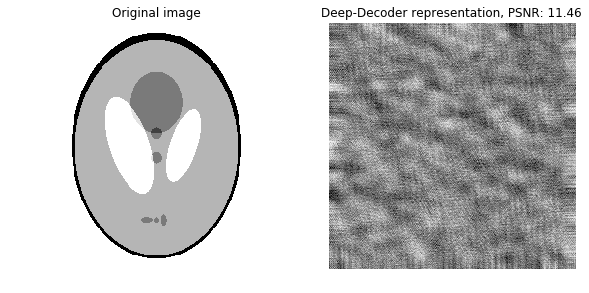

In [367]:
num_channels = [8]*15
output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=9,mode="mult").type(dtype)

comparison(img_np,net,net_input)

## Center and only learn bias

input provided
optimize with SGD 0.05
Compression factor:  0.8401189621577274 Actual loss 0.002239 Actual loss orig 0.002139  Noise Energy 0.000000 


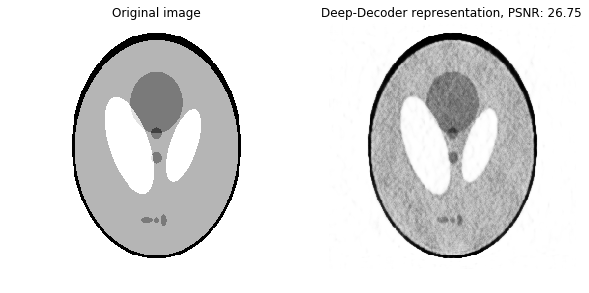

In [315]:
net = decnet(output_depth,num_channels,filter_size_up=9,mode="center+bias").type(dtype)
comparison(img_np,net,net_input)

## Only center and bias

input provided
optimize with SGD 0.05
Compression factor:  0.8401189621577274 Actual loss 0.071452 Actual loss orig 0.071452  Noise Energy 0.000000 


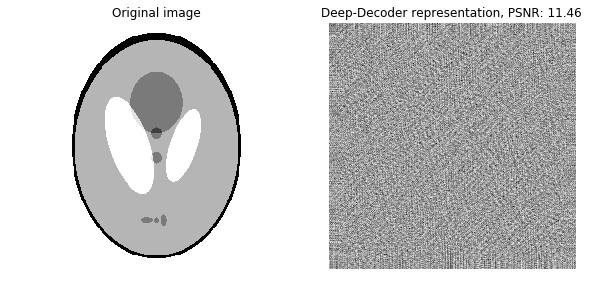

In [227]:
num_channels = [8]*15
net = decnet(output_depth,num_channels,filter_size_up=9,mode="onlycenter+bias").type(dtype)
comparison(img_np,net,net_input)

## Normalize and bias

input provided
optimize with SGD 0.05
Compression factor:  78.86401925391095  Actual loss 0.112279 Actual loss orig 0.112279  Noise Energy 0.000000 


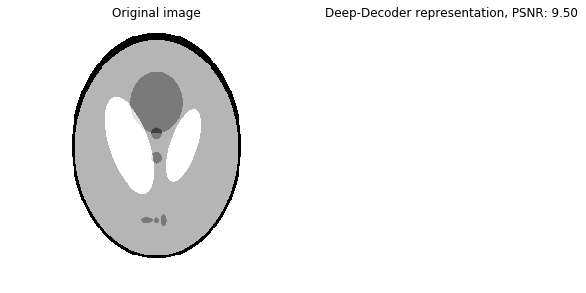

In [356]:
net = decnet(output_depth,num_channels,filter_size_up=9,mode="normalize+bias").type(dtype)
comparison(img_np,net,net_input)

In [365]:
#for m in net.modules():
#    if isinstance(m, nn.Conv2d):
#        print(m.weight.data.shape)
#        print(torch.norm(m.weight.data).cpu())#p='fro')
        #print(m.weights.data)

torch.Size([8, 8, 9, 9])
tensor(1.8974)
torch.Size([8, 8, 9, 9])
tensor(1.8075)
torch.Size([8, 8, 9, 9])
tensor(1.7730)
torch.Size([8, 8, 9, 9])
tensor(1.7600)
torch.Size([8, 8, 9, 9])
tensor(1.7320)
torch.Size([8, 8, 9, 9])
tensor(1.7371)
torch.Size([8, 8, 9, 9])
tensor(1.7147)
torch.Size([8, 8, 9, 9])
tensor(1.6962)
torch.Size([8, 8, 9, 9])
tensor(1.7157)
torch.Size([8, 8, 9, 9])
tensor(1.6954)
torch.Size([8, 8, 9, 9])
tensor(1.7025)
torch.Size([8, 8, 9, 9])
tensor(1.6927)
torch.Size([8, 8, 9, 9])
tensor(1.6940)
torch.Size([8, 8, 9, 9])
tensor(1.6635)
torch.Size([8, 8, 9, 9])
tensor(1.6666)
torch.Size([1, 8, 1, 1])
tensor(2.0252)


input provided
optimize with SGD 0.05
Compression factor:  0.8427116551795083 Actual loss 0.112279 Actual loss orig 0.112279  Noise Energy 0.000000 


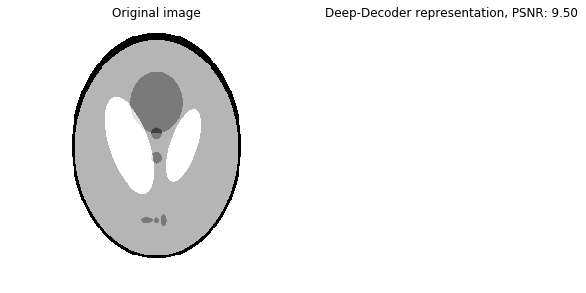

In [178]:
net = decnet(output_depth,num_channels,filter_size_up=9,mode="only+bias").type(dtype)
comparison(img_np,net,net_input)

## Scale

input provided
optimize with SGD 0.05
Compression factor:  0.8401189621577274 Actual loss 0.071452 Actual loss orig 0.071452  Noise Energy 0.000000 


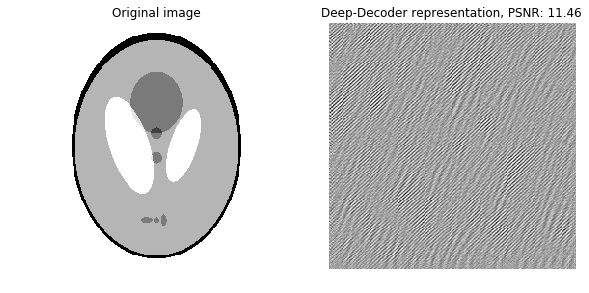

In [371]:
net = decnet(output_depth,num_channels,filter_size_up=9,mode="scale").type(dtype)
comparison(img_np,net,net_input)

# Single channel

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05
Compression factor:  0.9985525132940226 Actual loss 0.013205 Actual loss orig 0.013004  Noise Energy 0.000000 


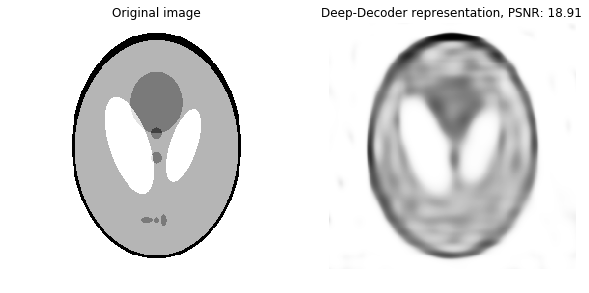

In [377]:
num_channels = [1]*10
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
net = decnet(output_depth,num_channels,filter_size_up=81,mode="BN").type(dtype)
comparison(img_np,net,net_input)

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05
Compression factor:  2.517613614536514  Actual loss 0.708165 Actual loss orig 0.708165  Noise Energy 0.000000 


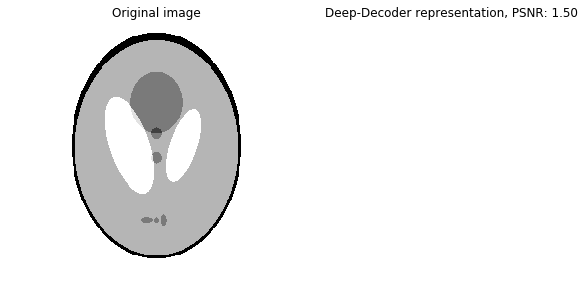

In [372]:
num_channels = [1]*10
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
net = decnet(output_depth,num_channels,filter_size_up=51,mode="only+bias").type(dtype)
comparison(img_np,net,net_input)

shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05
Compression factor:  25.167434715821813 Actual loss 0.071314 Actual loss orig 0.071313  Noise Energy 0.000000 


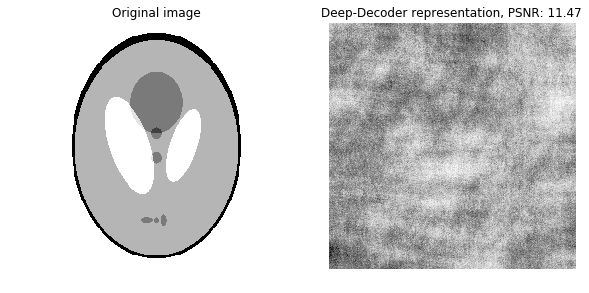

In [383]:
num_channels = [1]*1
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
net = decnet(output_depth,num_channels,filter_size_up=51,mode="only+bias").type(dtype)
comparison(img_np,net,net_input)

In [384]:
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        #print(m.weight.data.shape)
        print(torch.norm(m.weight.data).cpu())#p='fro')
        #print(m.weights.data)

tensor(0.9219)
tensor(0.7522)


shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05
Sequential(0990    Train loss 0.070779  Actual loss 0.070779 Actual loss orig 0.070779  Noise Energy 0.000000 
  (1): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (4): ChannelNormalization()
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Sigmoid()
)


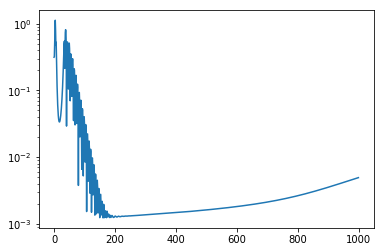

input provided
optimize with SGD 0.05
Sequential(0990    Train loss 0.050911  Actual loss 0.050911 Actual loss orig 0.050911  Noise Energy 0.000000 
  (1): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (4): ChannelNormalization()
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Sigmoid()
)


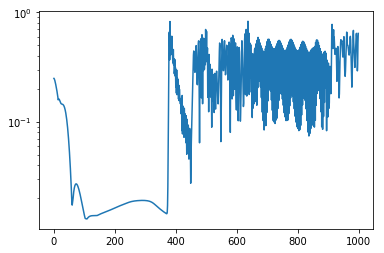

In [30]:
output_depth = img_np.shape[0] # number of output channels
net = decnet(output_depth,num_channels,filter_size_up=51,mode="BN").type(dtype)

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=1000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                        output_gradients=True,
                               )

print(net)
plt.semilogy(mse_n)
plt.show()

In [35]:
print(net)
for p in net.parameters():
    print(len(p.shape))

Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (4): ChannelNormalization()
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Sigmoid()
)
4
1
1
4
1
1
4


## Different initialization

In [18]:
print(net)

for m in net.modules():
    if isinstance(m, nn.Conv2d):
        print(m.weight.data)

Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (4): Sigmoid()
)
tensor([[[[ 0.0469, -0.0780, -0.0373, -0.0798,  0.0518, -0.0747, -0.0431,
            0.0980,  0.0308],
          [ 0.0123,  0.0797,  0.0851, -0.1036,  0.0165,  0.0193, -0.0928,
            0.0211, -0.0230],
          [ 0.0912, -0.0085, -0.0690, -0.0432, -0.0991,  0.0552, -0.0691,
            0.1030,  0.1021],
          [-0.0631,  0.0414, -0.0271, -0.0630,  0.0950, -0.0421, -0.0075,
           -0.0873, -0.0577],
          [-0.0615, -0.0305,  0.0725,  0.0731,  0.0615, -0.1061,  0.0845,
            0.0779, -0.0922],
          [-0.0514,  0.0749,  0.0106, -0.0155, -0.0740,  0.0589, -0.0040,
           -0.0898, -0.0388],
          [ 0.0893, -0.0232,  0.0028, -0.0897,  0.001

## Norms of gradients

In [387]:
p = [x for x in net.parameters() ]
img_var = np_to_var(img_np).type(dtype)
mse = torch.nn.MSELoss()
out = net(net_input.type(dtype))
loss = mse(out, img_var)
loss.backward()
for p in list(filter(lambda p: p.grad is not None, net.parameters())):
    print(p.grad.data.norm(2).item())

0.0006326684961095452
7.096468470990658e-05
0.00016770890215411782


In [382]:
print(net)

Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): ReflectionPad2d((25, 25, 25, 25))
    (1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), bias=False)
  )
  (4): ChannelNormalization()
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Sigmoid()
)


shape:  [1, 1, 256, 256]
input provided
optimize with SGD 0.05
Compression factor:  12.58613405031688  Actual loss 0.048391 Actual loss orig 0.048221  Noise Energy 0.000000 


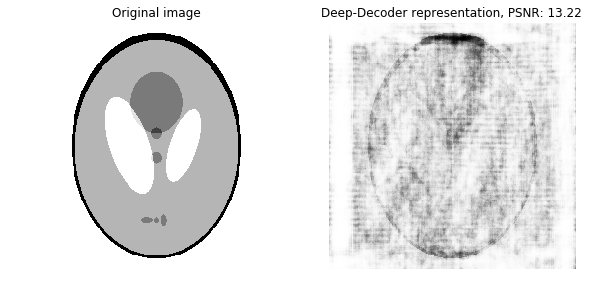

In [380]:
num_channels = [1]*2
shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
net = decnet(output_depth,num_channels,filter_size_up=51,mode="BN").type(dtype)
comparison(img_np,net,net_input)

In [352]:
num_channels = [1]*30
output_depth = img_np.shape[0] # number of output channels
net = decodernw(output_depth,num_channels_up=num_channels,upsample_mode='none',act_fun=None,filter_size_up=19).type(dtype)

width = img_np.shape[1]
height = img_np.shape[2]
shape = [1,num_channels[0], width, height]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
#comparison(img_np,net,net_input)

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = 500,
                        num_iter=20000,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='adam',
                               )

shape:  [1, 1, 256, 256]
input provided
optimize with adam 0.05


In [131]:
num_channels = [4]*1
net = decnet(3,num_channels).type(dtype)
print(net)


shape = [1,num_channels[0], img_np.shape[1], img_np.shape[2]]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./10
net(net_input.type(dtype))

Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): ReLU()
  (3): ChannelNormalization()
  (4): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (5): Sigmoid()
)
shape:  [1, 4, 256, 256]


tensor([[[[0.4962, 0.4960, 0.4966,  ..., 0.4958, 0.4952, 0.4948],
          [0.4955, 0.4942, 0.4958,  ..., 0.4956, 0.4945, 0.4948],
          [0.4922, 0.4954, 0.4978,  ..., 0.4949, 0.4951, 0.4937],
          ...,
          [0.4949, 0.4929, 0.4972,  ..., 0.4961, 0.4926, 0.4929],
          [0.4949, 0.4929, 0.4938,  ..., 0.4935, 0.4925, 0.4974],
          [0.4947, 0.4934, 0.4940,  ..., 0.4944, 0.4955, 0.4963]],

         [[0.5055, 0.5068, 0.4993,  ..., 0.5017, 0.5009, 0.5068],
          [0.5059, 0.5032, 0.5056,  ..., 0.4992, 0.5011, 0.5048],
          [0.5025, 0.5031, 0.5035,  ..., 0.5036, 0.5040, 0.5013],
          ...,
          [0.5002, 0.5016, 0.5008,  ..., 0.5018, 0.5021, 0.5014],
          [0.5067, 0.5016, 0.5029,  ..., 0.5016, 0.5017, 0.5051],
          [0.5024, 0.5033, 0.5053,  ..., 0.5057, 0.5065, 0.5030]],

         [[0.4982, 0.4970, 0.5037,  ..., 0.5023, 0.5036, 0.4981],
          [0.4984, 0.5022, 0.4985,  ..., 0.5050, 0.5041, 0.5001],
          [0.5048, 0.5012, 0.4986,  ..., 0

In [43]:
A = np.array( [[[[1,1],[1,1]], [[2,2],[2,2]] ] , [[[1,1],[1,1]], [[2,2],[2,2]] ] ] )
print(A.shape)
print(A)
c = np.array([1,2])
B = c * A 
print(B.shape)
print(A[:,:,:]*c)

print(A[0,0])

(1, 2, 2, 2)
[[[[1 1]
   [1 1]]

  [[2 2]
   [2 2]]]]
(1, 2, 2, 2)
[[[[1 2]
   [1 2]]

  [[2 4]
   [2 4]]]]
[[1 1]
 [1 1]]


In [58]:
A = np.array( [ [[[1,1],[1,1]], [[2,2],[2,2]]] , [[[1,1],[1,1]], [[2,2],[2,2]]] ] )
print(A.shape,A[0,0])
c = np.array([1,2])

for i,(a,b) in enumerate(zip(c,c)):
    print("a: ", A[0,i])
    A[:,i] = A[:,i]*a + b
    
print(A)

(2, 2, 2, 2) [[1 1]
 [1 1]]
a:  [[1 1]
 [1 1]]
a:  [[2 2]
 [2 2]]
[[[[2 2]
   [2 2]]

  [[6 6]
   [6 6]]]


 [[[2 2]
   [2 2]]

  [[6 6]
   [6 6]]]]


In [296]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.multp = Variable(torch.rand(1), requires_grad=True)

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.multp = nn.Parameter(torch.rand(1)) # requires_grad is True by default for Parameter

m1 = Model1()
m2 = Model2()

print('m1', list(m1.parameters()))
print('m2', list(m2.parameters()))

m1 []
m2 [Parameter containing:
tensor([0.4474], requires_grad=True)]


In [ ]:
def